# `numpyro` 8 schools example of hierarchical modeling

In [23]:
import numpy as np

# Data
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

Simplest example I can figure of using a plate:

In [24]:
# First, without the plate:

import numpyro
import numpyro.distributions as dist

def eight_schools_complete_pooling(J, sigma, y=None):
    mu = numpyro.sample('mu', dist.Normal(0, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    theta = numpyro.sample('theta', dist.Normal(mu, tau))
    return numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

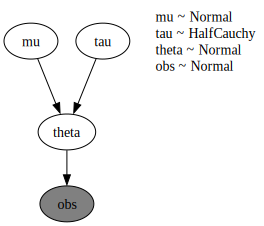

In [25]:
numpyro.render_model(eight_schools_complete_pooling, model_args=(J, sigma, y), render_distributions=True)

In [26]:
from jax import random
from numpyro.infer import MCMC, NUTS

nuts_kernel = NUTS(eight_schools_complete_pooling)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
rng_key = random.PRNGKey(0)  # always need to specify jax pseudorandom number generator key
mcmc.run(rng_key, J, sigma, y=y, extra_fields=('potential_energy',))

sample: 100%|██████████| 1500/1500 [00:01<00:00, 1268.13it/s, 7 steps of size 3.87e-01. acc. prob=0.76]


In [27]:
import arviz as az

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

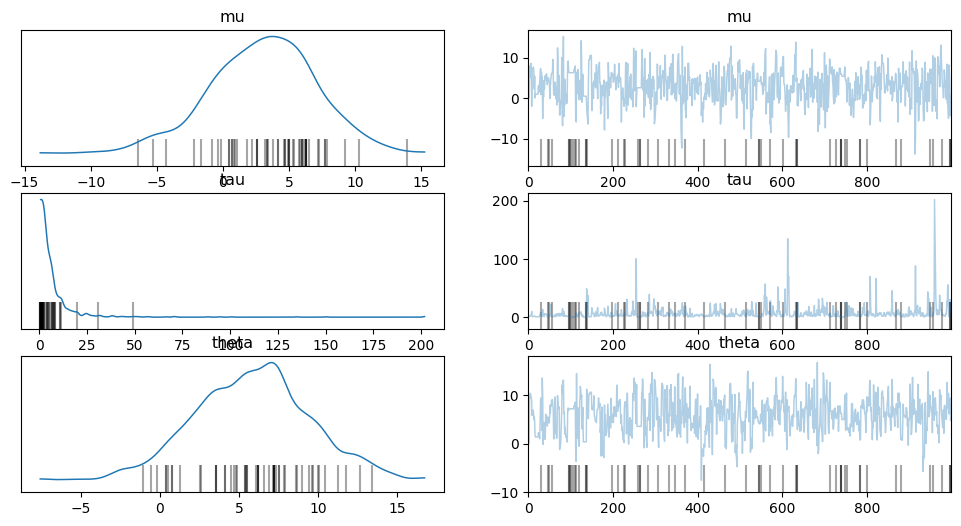

In [28]:
az.plot_trace(mcmc)

In [29]:
import numpyro
import numpyro.distributions as dist

def eight_schools(J, sigma, y=None):
    """
    Hierarchical model of the eight schools example where we assume group-level parameters theta for
    each school are sampled from an unknown mean mu and std dev tau.
    """
    # Group-level parameters
    mu = numpyro.sample('mu', dist.Normal(0,5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    # Create a plate named 'J', one for each school
    with numpyro.plate('J', J):
        theta = numpyro.sample('theta', dist.Normal(mu, tau))
        numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)


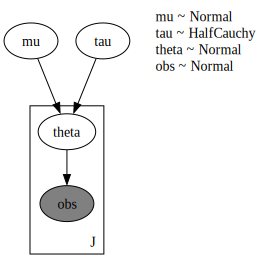

In [30]:
numpyro.render_model(eight_schools, model_args=(J, sigma, y), render_distributions=True)

Inference with MCMC

In [31]:
from jax import random
from numpyro.infer import MCMC, NUTS

nuts_kernel = NUTS(eight_schools)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
rng_key = random.PRNGKey(0)  # always need to specify jax pseudorandom number generator key
mcmc.run(rng_key, J, sigma, y=y, extra_fields=('potential_energy',))

sample: 100%|██████████| 1500/1500 [00:01<00:00, 1291.91it/s, 31 steps of size 6.07e-02. acc. prob=0.75]


In [32]:
# inspect results
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      4.48      2.88      5.14     -0.66      8.88    116.32      1.05
       tau      2.59      2.60      1.83      0.22      6.07     12.80      1.17
  theta[0]      5.65      4.24      5.74     -1.52     12.17    182.43      1.00
  theta[1]      4.82      3.96      5.37     -1.61     11.47    246.74      1.02
  theta[2]      4.26      4.16      5.30     -2.94      9.97    199.61      1.05
  theta[3]      4.68      4.02      5.36     -1.36     11.70    212.51      1.02
  theta[4]      3.89      3.95      4.85     -3.23      9.25    115.18      1.06
  theta[5]      4.28      4.14      5.30     -2.46     10.35    179.70      1.03
  theta[6]      5.87      4.12      5.70     -0.27     12.99    157.47      1.00
  theta[7]      4.77      4.14      5.31     -3.17     10.03    195.87      1.01

Number of divergences: 105


Note the values above 1 for the $\hat{r}$ Gelman Rubin diagnostic indicate that the chains have not fully converged and the number of effective samples `n_eff` is quite low

In [33]:
# compute expected log joint density:
pe = mcmc.get_extra_fields()['potential_energy']
print('Expected log joint density: {:.2f}'.format(np.mean(-pe)))  # doctest: +SKIP

Expected log joint density: -49.01


In [34]:
from numpyro.infer.reparam import TransformReparam

# Eight Schools example - Non-centered Reparametrization
def eight_schools_noncentered(J, sigma, y=None):
    mu = numpyro.sample('mu', dist.Normal(0, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    with numpyro.plate('J', J):
        with numpyro.handlers.reparam(config={'theta': TransformReparam()}):
            theta = numpyro.sample(
                'theta',
                dist.TransformedDistribution(dist.Normal(0., 1.),
                                             dist.transforms.AffineTransform(mu, tau)))
        numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

nuts_kernel = NUTS(eight_schools_noncentered)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, J, sigma, y=y, extra_fields=('potential_energy',))
mcmc.print_summary(exclude_deterministic=False)  # doctest: +SKIP

sample: 100%|██████████| 1500/1500 [00:01<00:00, 1325.17it/s, 7 steps of size 5.60e-01. acc. prob=0.85]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
           mu      4.39      3.37      4.43     -1.05      9.97   1314.87      1.00
          tau      3.47      3.14      2.65      0.00      7.26    560.50      1.00
     theta[0]      6.03      5.33      5.52     -2.15     13.70    986.55      1.00
     theta[1]      4.92      4.80      4.79     -3.42     12.19   1309.33      1.00
     theta[2]      3.72      5.27      4.10     -5.53     10.87   1142.09      1.00
     theta[3]      4.72      4.95      4.66     -3.72     11.95   1064.31      1.00
     theta[4]      3.68      4.53      3.78     -4.03     11.07   1648.88      1.00
     theta[5]      3.94      4.86      4.14     -3.21     12.08   1264.84      1.00
     theta[6]      6.34      4.86      5.84     -1.12     14.06   1337.47      1.00
     theta[7]      4.58      4.81      4.59     -2.72     12.57   1045.19      1.00
theta_base[0]      0.27      0.91      0.30     -1.23      1.71   1232.75  

In [35]:
pe = mcmc.get_extra_fields()['potential_energy']
# Compare with the earlier value
print('Expected log joint density: {:.2f}'.format(np.mean(-pe)))  # doctest: +SKIP

Expected log joint density: -46.24


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'theta_base'}>,
        <Axes: title={'center': 'theta_base'}>]], dtype=object)

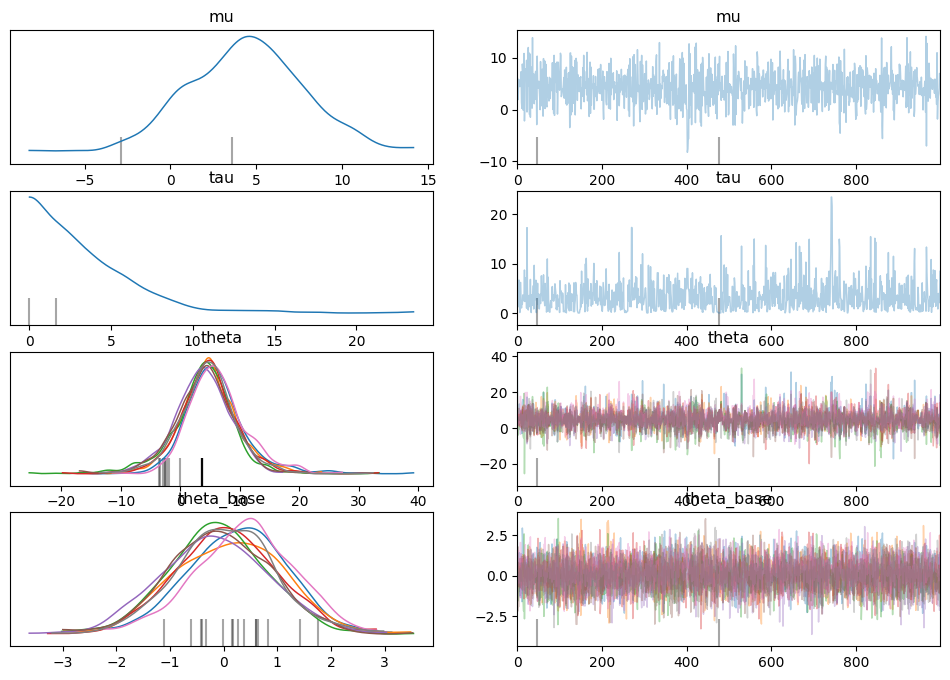

In [36]:
az.plot_trace(mcmc)

## Prediction

The `Predictive` utility is used for both prior predictive and posterior predictive sampling - the only difference you provide `posterior_samples` in the call

In [41]:
from numpyro.infer import Predictive

# New School
def new_school():
    mu = numpyro.sample('mu', dist.Normal(0, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    return numpyro.sample('obs', dist.Normal(mu, tau))

posterior_samples = mcmc.get_samples()
# Predictive() conditions the unobserved mu and tau from posterior distributions to generate predictions
predictive = Predictive(new_school, posterior_samples=posterior_samples)
# 1000 samples from the posterior
samples_predictive = predictive(random.PRNGKey(1))
print(np.mean(samples_predictive['obs'])) 

4.600406


In [46]:
prior_predictive = Predictive(new_school, num_samples=100)
prior_predictive_samples = prior_predictive(random.PRNGKey(42))['obs']

In [48]:
prior_predictive_samples.shape

(100,)

In [10]:
mcmc.get_samples().keys()

dict_keys(['mu', 'tau', 'theta', 'theta_base'])

In [11]:
# 1000 samples from the posterior
samples_predictive['obs'].shape

(1000,)